<a href="https://colab.research.google.com/github/2mur/stereo-street/blob/main/report_googlemaps_path_elevation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Part 1**: Data Collection
using google maps API, from initial coordinates a path is constructed across a street to find unique viewpoints and collect their metadata;

*pano\_id, elevation, panorama coordinates,*

In [ ]:
import requests
import json
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

API_KEY = 'insert key here'

**1.1** Building path from initial coordinate and final coordinate

In [ ]:
#along the st-mathieu street, from sherbrook to maisoneuve.
x0= 45.495713725557536; y0= -73.58250972897773
xf = 45.49456020005086; yf= -73.58055820541125

nrange=20 #try 20 points as resolution to find unique panorama viewpoints

lat_range = np.linspace(x0,xf,nrange)
lng_range = np.linspace(y0,yf,nrange)

**1.2** getting panorama for first point

In [ ]:
meta_endpoint = 'https://maps.googleapis.com/maps/api/streetview/metadata'

meta_params = {
      'location': '{},{}'.format(lat_range[0],lng_range[0]),
      'key': API_KEY,
  }
meta_image_data = requests.get(meta_endpoint, params=meta_params)
imgmeta = meta_image_data.json()
imgmeta

{'copyright': '© Google',
 'date': '2017-07',
 'location': {'lat': 45.4957101245606, 'lng': -73.58250496445334},
 'pano_id': 'fmnmA6ZrzM38gcPGd6jlJQ',
 'status': 'OK'}

**1.3** difference between input and output points
geographic coordinate to meters,

latitude conversion

1deg : 111132.92-559.82*cos(2*phi)+1.175*cos(4*phi)-0.0023*cos(6*phi) → 1m

longitude conversion

1deg : 111412.84*cos(deg)-93.5*cos(3*deg)+0.118*cos(5*deg) → 1m



In [ ]:
deg0 = (lat_range[0],lng_range[0])
degf = (imgmeta['location']['lat'],imgmeta['location']['lng'])

def lat_to_meter(deg):
  return(111132.92 -559.82*np.cos(2*deg)+1.175*np.cos(4*deg)-0.0023*np.cos(6*deg))
def lng_to_meter(deg):
  return(111412.84*np.cos(deg)-93.5*np.cos(3*deg)+0.118*np.cos(5*deg))

def get_dist_meter(deg0,degf):
  phi0,theta0 = deg0
  phif,thetaf = degf

  dx = lat_to_meter(phi0)-lat_to_meter(phif)
  dy = lng_to_meter(theta0)-lng_to_meter(thetaf)
  d = np.sqrt(dx**2 + dy**2)
  return(d)

x0,y0 = deg0
xf,yf = degf

print('(x0,y0) = (', lat_to_meter(x0),',',lng_to_meter(y0),')')
print('(xf,yf) = (', lat_to_meter(xf),',',lng_to_meter(yf),')')

#the distance calculation will serve as the baseline length
print('distance between two vectors', get_dist_meter(deg0,degf))


(x0,y0) = ( 111690.2040527581 , -27077.779686707137 )
(xf,yf) = ( 111690.20358720148 , -27078.295666806203 )
distance between two vectors 0.5159803090962356


**1.4** get all unique panoramas in a list, and their locations in (lat,lng)

In [ ]:
'''
example of metadata request
{'copyright': '© Google',
 'date': '2017-07',
 'location': {'lat': 45.4957101245606, 'lng': -73.58250496445334},
 'pano_id': 'fmnmA6ZrzM38gcPGd6jlJQ',
 'status': 'OK'}
'''

pano_id_list = []
pano_deg_list = []
for i in range(nrange):
  meta_params = {
      'location': '{},{}'.format(lat_range[i],lng_range[i]),
      'key': API_KEY,
  }
  meta_image_data = requests.get(meta_endpoint, params=meta_params)
  imgmeta = meta_image_data.json()

  pano_deg = (imgmeta['location']['lat'],imgmeta['location']['lng'])
  pano_id = imgmeta['pano_id']
  if pano_id not in pano_id_list:
    pano_id_list.append(pano_id)
    pano_deg_list.append(pano_deg)

**1.5** get elevation for all found viewpoints

In [ ]:
path1 = ['{}%2C{}%7C'.format(e1, e2) for e1,e2 in pano_deg_list]
path1 = ''.join(path1)[:-3]
path2 = ['{},{}'.format(e1, e2) for e1,e2 in pano_deg_list]
path3 = ['{},{}|'.format(e1, e2) for e1,e2 in pano_deg_list]
path3 = ''.join(path3)[:-1]

pano_lat = [e1 for e1,e2 in pano_deg_list]
pano_lng = [e2 for e1,e2 in pano_deg_list]

In [ ]:
elev_endpoint = 'https://maps.googleapis.com/maps/api/elevation/json'
elev_params = {
      'locations': path3,
      'key': API_KEY,
  }
elev_req = requests.get(elev_endpoint, params=elev_params)
elev_data = elev_req.json()

**1.6** Store collected data
cols: pano_id, lat, lng, elev, lat_m (meters), lng_m, baseline_l (baseline length as left pair), baseline_r (baseline length as right pair),

In [ ]:
pano_elev_list = [e['elevation'] for e in elev_data['results']]

stereo_dataset = pd.DataFrame(data= {'pano_id' : pano_id_list,
                              'lat' : pano_lat,
                              'lng' : pano_lng,
                              'elev' : pano_elev_list})

stereo_dataset.to_csv('stereo_dataset.csv')

,pano_id,lat,lng,elev
0,fmnmA6ZrzM38gcPGd6jlJQ,45.495710,-73.582505,57.902134
1,OgM8drL2r2xhDNR-bQlrxQ,45.495648,-73.582403,57.487469
2,thh4EXIvb6-Rv6oKjZekKQ,45.495590,-73.582309,57.088661
3,7C_x_Joul6xEg_Mo3qMvFA,45.495528,-73.582209,56.653671
4,3ZvByPqo5I-v_H932hy6Ug,45.495468,-73.582111,56.222157
5,xhREBhaLgopJl46Qn5pIDg,45.495412,-73.582019,55.811348
6,gr_aMAzme5aQE7ny6v7BCg,45.495337,-73.581898,55.271790
7,3nGtmEN35TciS5XU9TbInw,45.495269,-73.581787,54.775806
8,TkAvmQBSF5JKbS_1NqFoKQ,45.495208,-73.581688,54.340405
9,p14EIFt10EXo1PR_HPJaEQ,45.495126,-73.581555,53.759083


In [ ]:
#make graph with nodes as panorama locations
Gpano = nx.DiGraph()
Gpano.add_nodes_from(pano_id_list)
for i in range(len(pano_id_list)-1):
  Gpano.add_edge(pano_id_list[i],pano_id_list[i+1],
                 distance = get_dist_meter(pano_deg_list[i],pano_deg_list[i+1]))

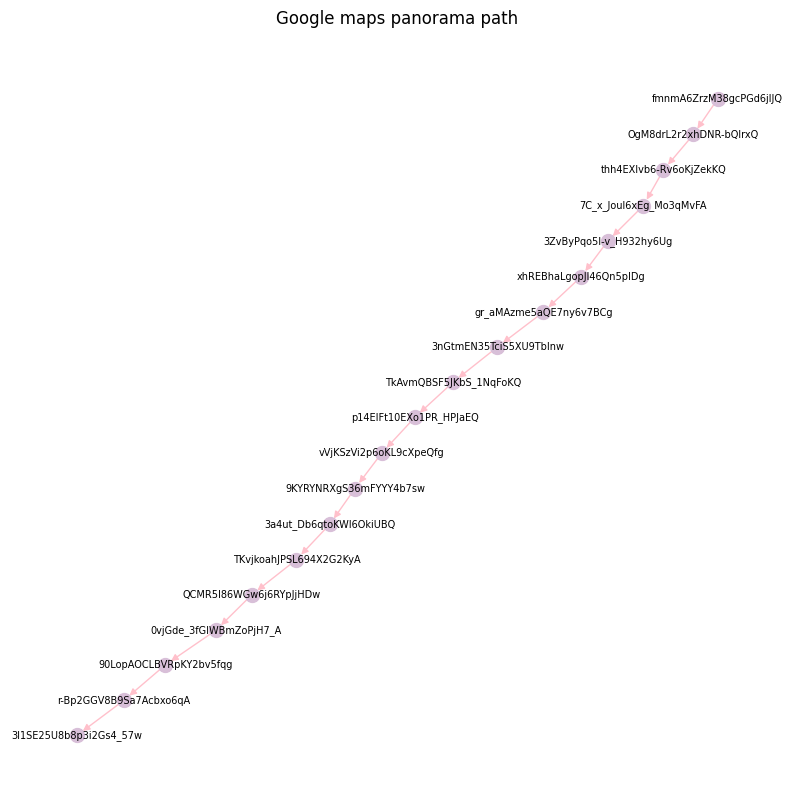

In [ ]:
#draw the path as a graph
x = []; y= []
dx =[]; dy =[]
xnorm = [0]; ynorm = [0]

for i in range(len(pano_deg_list)):
  lat,lng = pano_deg_list[i]
  x.append(lat_to_meter(lat))
  y.append(lng_to_meter(lng))
  if i>0:
    plat,plng = pano_deg_list[i-1]
    dx = 111139*(lat-plat); dy = 111139*(lng-plng)
    xp = xnorm[i-1]; yp = ynorm[i-1]
    xnorm.append(xp+dx); ynorm.append(yp+dy)

xnorm = [-x for x in xnorm]; ynorm = [-y for y in ynorm]

params = {'with_labels': True, 'width' : 1, 'node_color': 'thistle',
          'font_size':7, 'node_size':100 , 'edge_color':'pink'}

plt.figure(figsize=(10,10), dpi = 100)
plt.title('Google maps panorama path')
pos = nx.kamada_kawai_layout(Gpano)
nx.draw(Gpano, pos, **params)
plt.axis('off')
plt.show()